In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
mspec_train_x = np.load("lmfcc_train_x_dy.npz")["X"]
mspec_val_x   = np.load("lmfcc_val_x_dy.npz")["X"]

train_y = np.load("train_y_dy.npz")["y"]
val_y   = np.load("val_y_dy.npz")["y"]


train_x = torch.tensor(mspec_train_x, dtype=torch.float32)
val_x   = torch.tensor(mspec_val_x, dtype=torch.float32)


train_y = torch.tensor(train_y, dtype=torch.long)
val_y   = torch.tensor(val_y, dtype=torch.long)

# add noise to the training data
noise_std = 0.01
augmented_train_x = train_x + noise_std * torch.randn_like(train_x)

input_dim = mspec_train_x.shape[1]
hidden_dim = 256
output_dim = len(torch.unique(train_y))
batch_size = 256
num_epochs = 100
learning_rate = 1e-3
patience = 3

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_loader = DataLoader(TensorDataset(augmented_train_x, train_y), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(val_x, val_y),     batch_size=batch_size)

writer = SummaryWriter()

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader.dataset)
    accuracy = correct / total

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {accuracy:.4f}")
    writer.add_scalars("Loss", {"Train": train_loss, "Val": val_loss}, epoch)
    writer.add_scalar("Accuracy/Val", accuracy, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(net.state_dict(), "model_mspec_dy_2layer.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


Epoch 1: Train Loss = 0.8427, Val Loss = 0.7481, Val Acc = 0.7524
Epoch 2: Train Loss = 0.6496, Val Loss = 0.6695, Val Acc = 0.7748
Epoch 3: Train Loss = 0.5927, Val Loss = 0.6692, Val Acc = 0.7749
Epoch 4: Train Loss = 0.5668, Val Loss = 0.6369, Val Acc = 0.7848
Epoch 5: Train Loss = 0.5504, Val Loss = 0.6606, Val Acc = 0.7791
Epoch 6: Train Loss = 0.5382, Val Loss = 0.6264, Val Acc = 0.7902
Epoch 7: Train Loss = 0.5291, Val Loss = 0.6213, Val Acc = 0.7928
Epoch 8: Train Loss = 0.5221, Val Loss = 0.6274, Val Acc = 0.7918
Epoch 9: Train Loss = 0.5159, Val Loss = 0.6350, Val Acc = 0.7899
Epoch 10: Train Loss = 0.5110, Val Loss = 0.6313, Val Acc = 0.7913
Early stopping triggered at epoch 10


In [3]:
mspec_test_x = np.load("lmfcc_test_x_dy.npz")['X']
test_y = np.load("test_y_dy.npz")['y']

test_x_tensor = torch.tensor(mspec_test_x, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.long)

net.eval()

with torch.no_grad():
    outputs = net(test_x_tensor)
    _, predicted = torch.max(outputs, 1)


In [4]:
accuracy = (predicted == test_y_tensor).sum() / len(test_y_tensor)
print(f" frame-by-frame at the state level accuracy: {accuracy:.4f}")


 frame-by-frame at the state level accuracy: 0.7729


In [5]:
phoneHMMs = np.load('../../lab2/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
stateList

['ah_0',
 'ah_1',
 'ah_2',
 'ao_0',
 'ao_1',
 'ao_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'eh_0',
 'eh_1',
 'eh_2',
 'ey_0',
 'ey_1',
 'ey_2',
 'f_0',
 'f_1',
 'f_2',
 'ih_0',
 'ih_1',
 'ih_2',
 'iy_0',
 'iy_1',
 'iy_2',
 'k_0',
 'k_1',
 'k_2',
 'n_0',
 'n_1',
 'n_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'r_0',
 'r_1',
 'r_2',
 's_0',
 's_1',
 's_2',
 'sil_0',
 'sil_1',
 'sil_2',
 'sp_0',
 't_0',
 't_1',
 't_2',
 'th_0',
 'th_1',
 'th_2',
 'uw_0',
 'uw_1',
 'uw_2',
 'v_0',
 'v_1',
 'v_2',
 'w_0',
 'w_1',
 'w_2',
 'z_0',
 'z_1',
 'z_2']

In [6]:
len(stateList)

61

In [7]:
example_input = test_x_tensor[0:80]
example_target = test_y[0:80]

with torch.no_grad():
    output_frame = net(example_input)
    posteriors = F.softmax(output_frame, 1).numpy()
posteriors[0]

array([3.3241643e-06, 4.0559125e-06, 2.2467273e-06, 9.5593014e-06,
       1.9946849e-05, 1.6649854e-05, 5.5447690e-06, 2.4741994e-06,
       2.7917301e-06, 6.5897589e-06, 4.1740586e-06, 3.3775875e-06,
       6.2888408e-05, 3.0883518e-06, 1.1950141e-05, 2.3010018e-04,
       1.5753207e-06, 1.6222172e-06, 3.3248361e-06, 1.8478307e-06,
       6.0017837e-06, 2.2168357e-05, 1.5296011e-05, 1.3054905e-05,
       8.1688104e-06, 1.5889949e-03, 3.8026594e-06, 3.2434229e-05,
       3.1042528e-06, 1.2787421e-04, 1.8875484e-05, 9.5584392e-07,
       1.5777345e-05, 4.5469511e-05, 1.5621799e-05, 1.2056784e-05,
       4.2341338e-04, 2.4783190e-05, 1.5171724e-05, 6.4591694e-01,
       1.0495850e-02, 3.3475584e-01, 3.5820880e-03, 1.9188060e-03,
       6.6439803e-05, 5.8590664e-05, 2.3486854e-04, 1.7787055e-07,
       4.2486081e-07, 5.1103316e-06, 1.4841848e-06, 5.8249611e-06,
       2.1239659e-06, 7.2816215e-07, 9.9854778e-06, 1.4789929e-05,
       9.0915601e-06, 4.0912569e-06, 1.2171185e-04, 2.3002679e

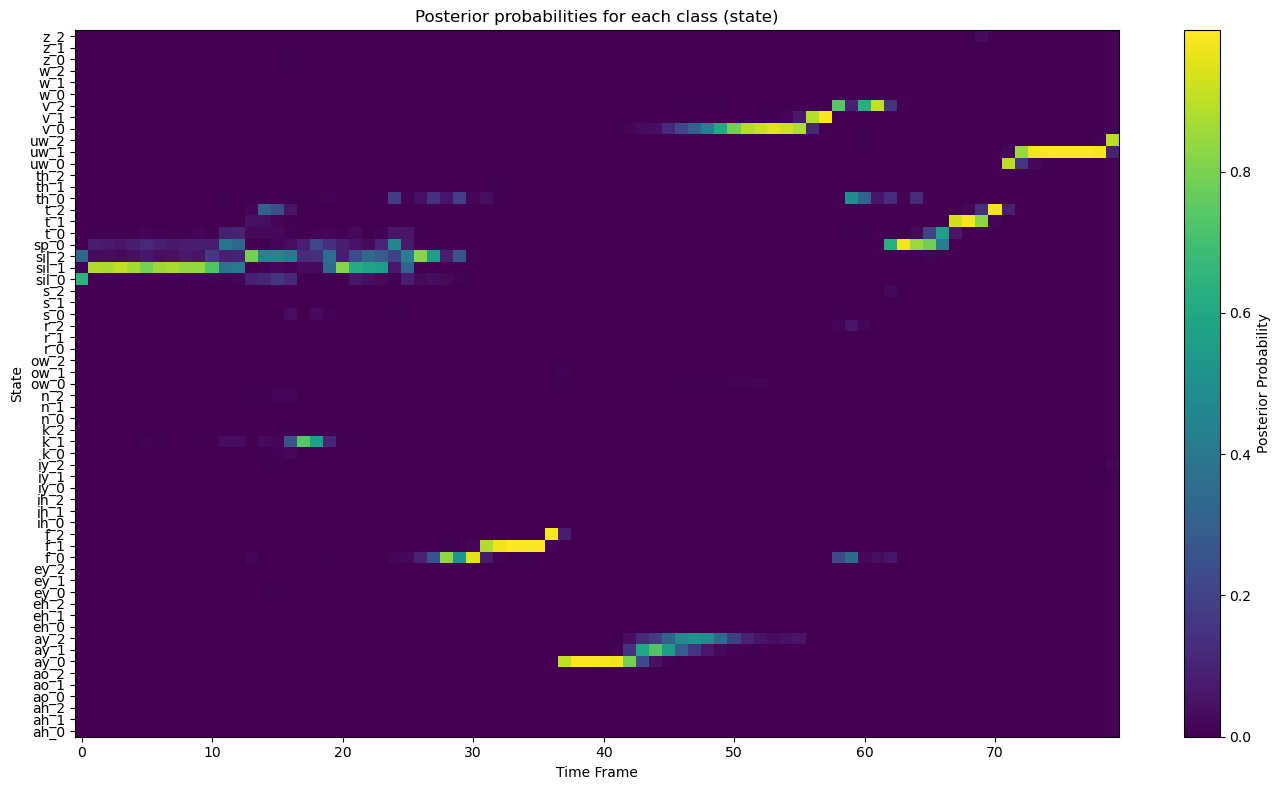

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.imshow(posteriors.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Posterior Probability')
plt.ylabel('State')
plt.xlabel('Time Frame')
plt.title('Posterior probabilities for each class (state)')
plt.yticks(ticks=np.arange(len(stateList))[::1], labels=stateList[::1])
plt.tight_layout()
plt.show()

In [9]:
print([stateList[idx] for idx in example_target])
print([stateList[idx] for idx in np.argmax(posteriors, 1)])

['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'f_0', 'f_0', 'f_0', 'f_0', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_2', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'ay_1', 'ay_1', 'ay_1', 'ay_1', 'ay_1', 'ay_2', 'v_0', 'v_0', 'v_0', 'v_0', 'v_0', 'v_0', 'v_0', 'v_1', 'v_1', 'v_2', 'v_2', 'v_2', 'v_2', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 't_0', 't_1', 't_1', 't_2', 't_2', 'uw_0', 'uw_1', 'uw_1', 'uw_1', 'uw_1', 'uw_1', 'uw_1', 'uw_1', 'uw_2']
['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sp_0', 'sil_1', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'k_1', 'k_1', 'sil_2', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sp_0', 'sil_2', 'sil_2', 'sil_2', 'f_0', 'f_0', 'f_0', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_2', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'a

# frame-by-frame at the state level

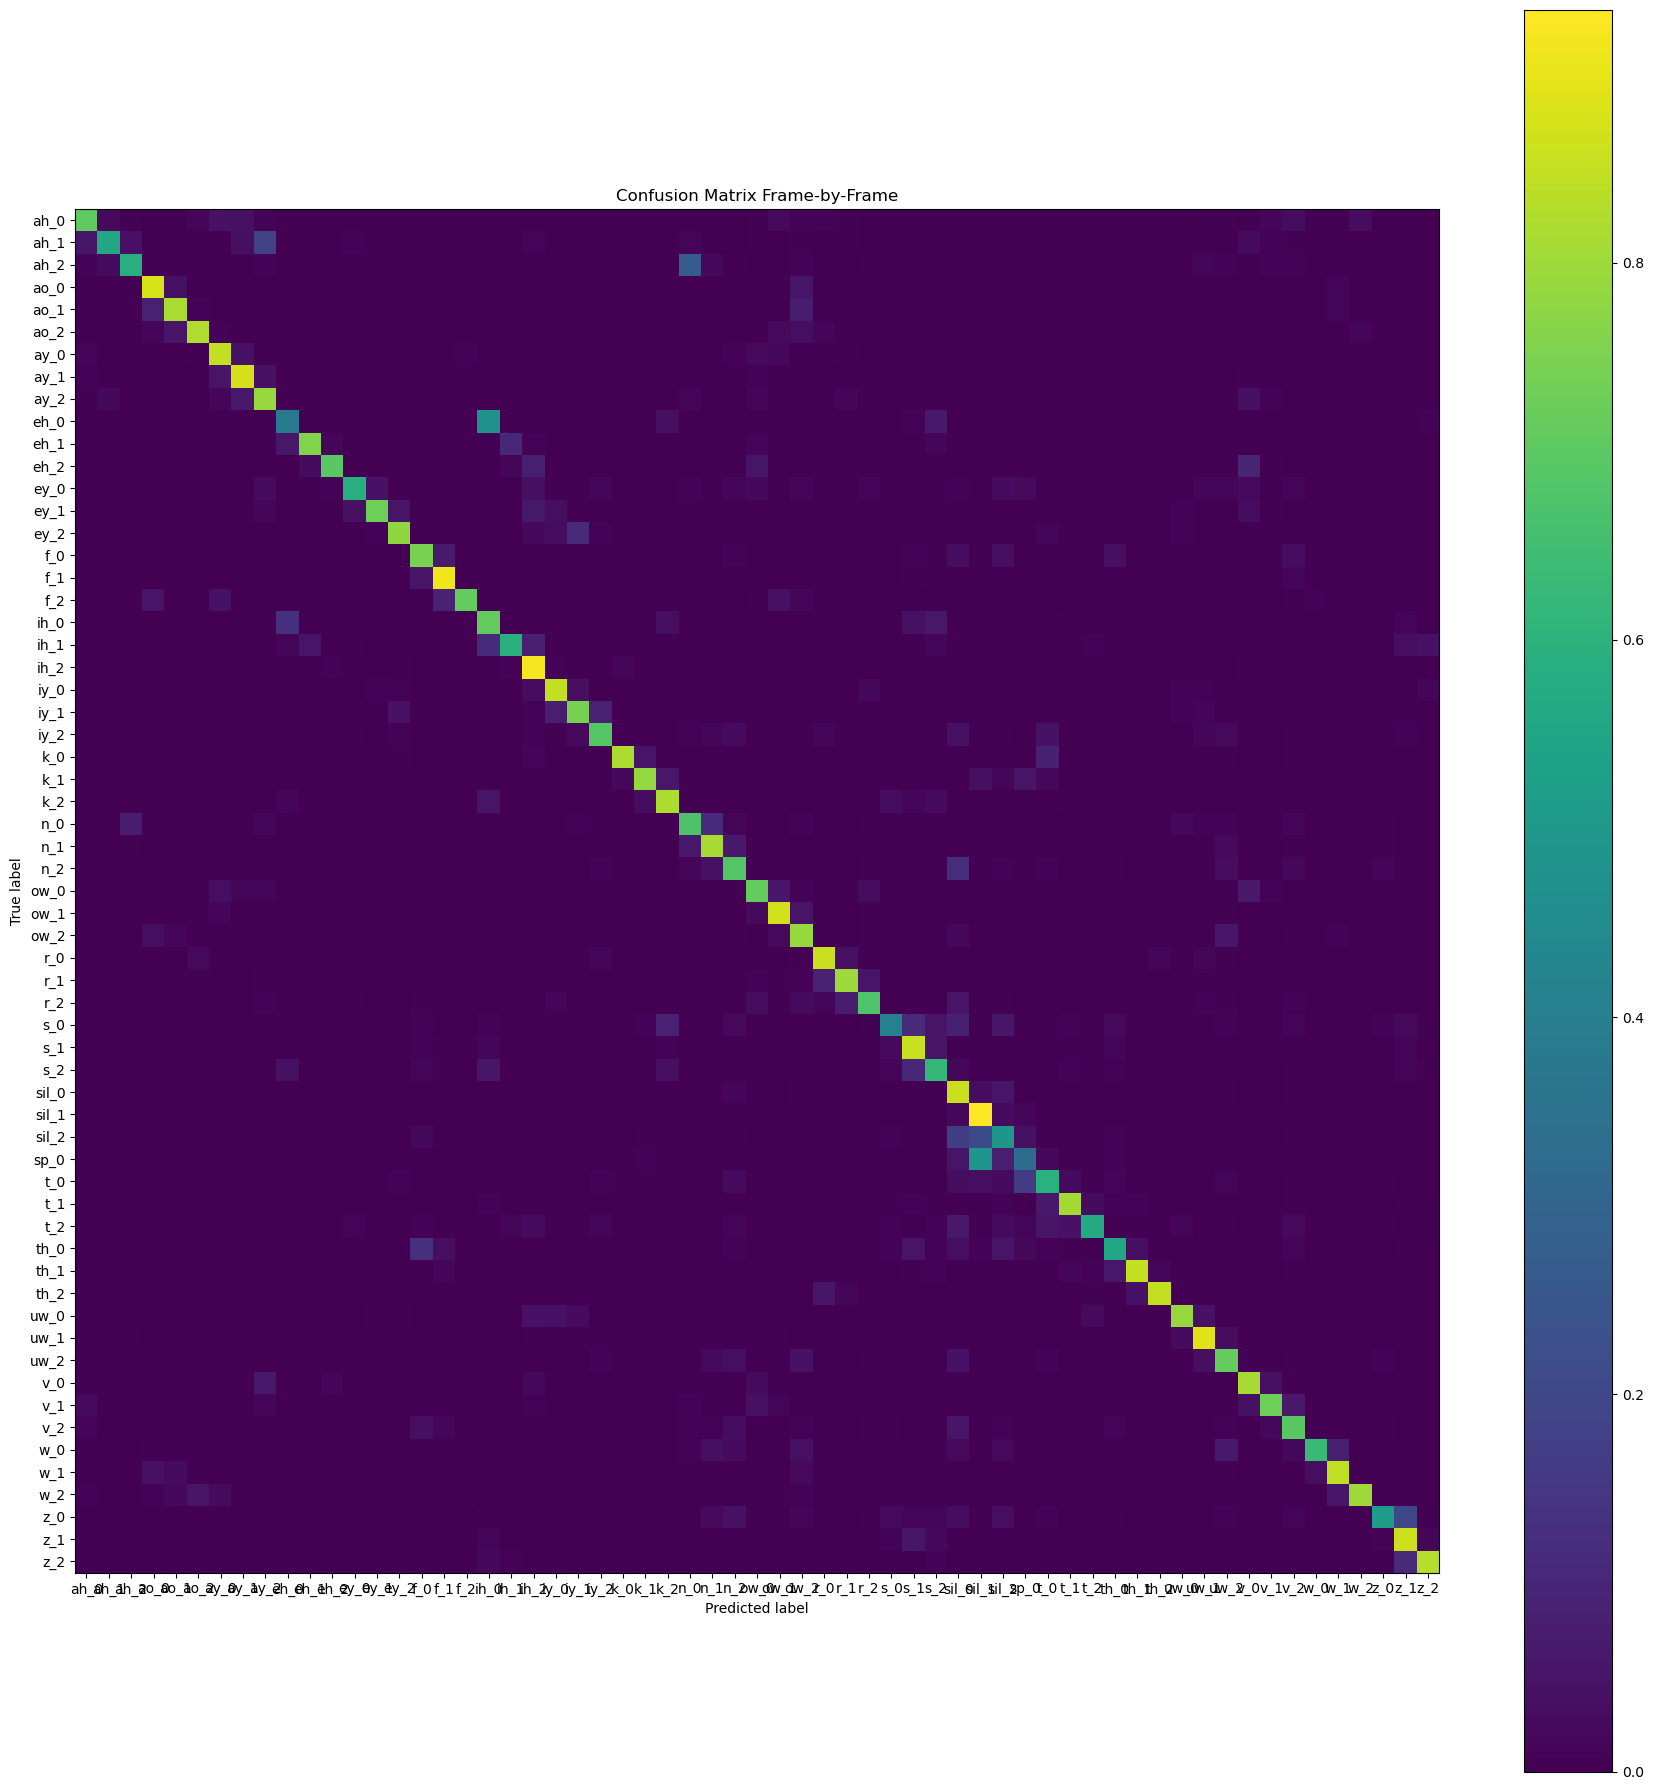

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_M = confusion_matrix(test_y_tensor, predicted, normalize='true')
confusion_D = ConfusionMatrixDisplay(confusion_matrix=confusion_M, display_labels=stateList)
fig, ax = plt.subplots(figsize=(18, 18))
confusion_D.plot(include_values=False,ax=ax)

plt.title("Confusion Matrix Frame-by-Frame")
plt.tight_layout()
plt.show()

# frame-by-frame at the phoneme level

 Frame accuracy at phoneme level: 0.8574


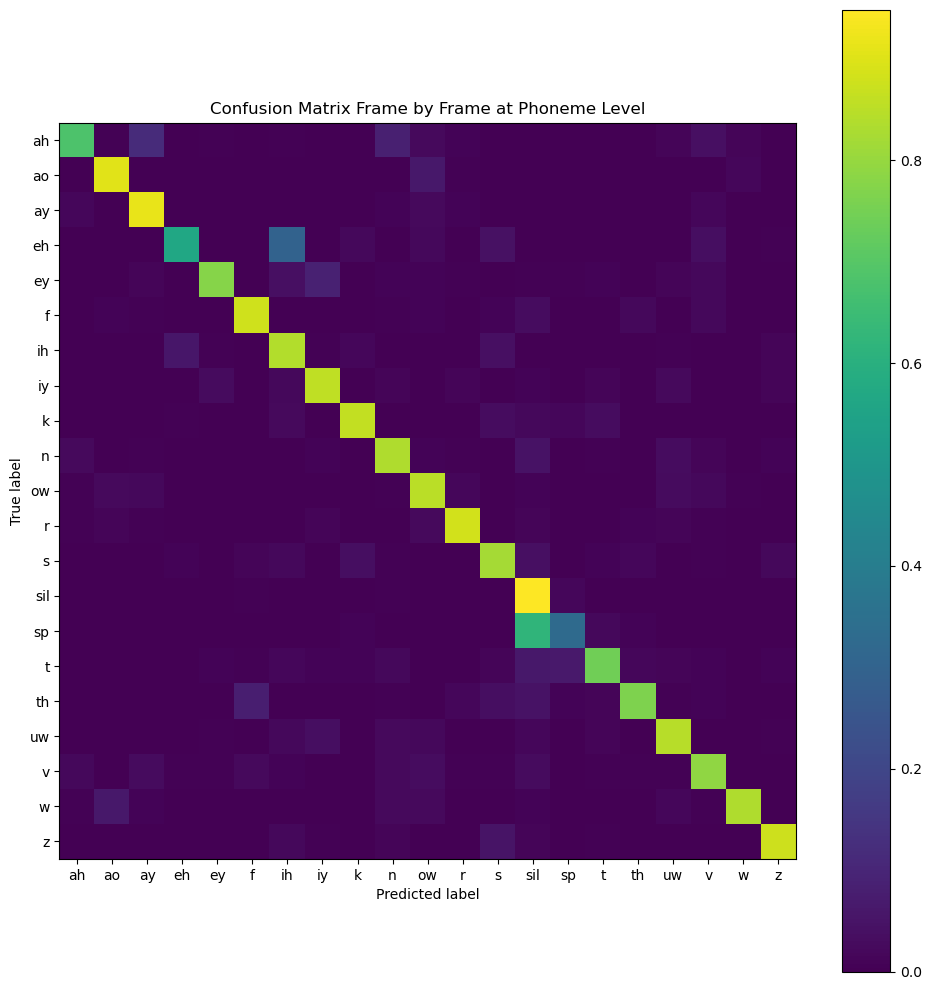

In [22]:
phoneList = [state.split("_")[0] for state in stateList]
phone_predict = [phoneList[idx] for idx in predicted.numpy()]
phone_y       = [phoneList[idx] for idx in test_y_tensor.numpy()]

accuracy_ph = np.mean(np.array(phone_predict) == np.array(phone_y))
print(f" Frame accuracy at phoneme level: {accuracy_ph:.4f}")

labels = sorted(set(phoneList))
confusion_D_F = confusion_matrix(phone_y, phone_predict, normalize='true')
display_F = ConfusionMatrixDisplay(confusion_matrix=confusion_D_F, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
display_F.plot(include_values=False, ax=ax)
plt.title("Confusion Matrix Frame by Frame at Phoneme Level")
plt.tight_layout()
plt.show()

In [12]:
stateList

['ah_0',
 'ah_1',
 'ah_2',
 'ao_0',
 'ao_1',
 'ao_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'eh_0',
 'eh_1',
 'eh_2',
 'ey_0',
 'ey_1',
 'ey_2',
 'f_0',
 'f_1',
 'f_2',
 'ih_0',
 'ih_1',
 'ih_2',
 'iy_0',
 'iy_1',
 'iy_2',
 'k_0',
 'k_1',
 'k_2',
 'n_0',
 'n_1',
 'n_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'r_0',
 'r_1',
 'r_2',
 's_0',
 's_1',
 's_2',
 'sil_0',
 'sil_1',
 'sil_2',
 'sp_0',
 't_0',
 't_1',
 't_2',
 'th_0',
 'th_1',
 'th_2',
 'uw_0',
 'uw_1',
 'uw_2',
 'v_0',
 'v_1',
 'v_2',
 'w_0',
 'w_1',
 'w_2',
 'z_0',
 'z_1',
 'z_2']

# edit distance at the state level:

In [13]:
state_pred = [stateList[idx] for idx in predicted.numpy()]
state_true = [stateList[idx] for idx in test_y_tensor.numpy()]

def mergestate(state_list):
    merged = [state_list[0]]
    for item in state_list[1:]:
        if item != merged[-1]:
            merged.append(item)
    return merged

merged_pred_state = mergestate(state_pred)
merged_true_state = mergestate(state_true)
merged_pred_state[:20]



['sil_0',
 'sil_1',
 'sp_0',
 'sil_1',
 'sil_2',
 'k_1',
 'sil_2',
 'sil_1',
 'sp_0',
 'sil_2',
 'f_0',
 'f_1',
 'f_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'v_0',
 'v_1',
 'v_2',
 'th_0']

In [14]:
merged_true_state[:20]

['sil_0',
 'sil_1',
 'sil_2',
 'f_0',
 'f_1',
 'f_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'v_0',
 'v_1',
 'v_2',
 'sp_0',
 't_0',
 't_1',
 't_2',
 'uw_0',
 'uw_1',
 'uw_2',
 's_0']

In [15]:
import editdistance

distance = editdistance.eval(merged_pred_state, merged_true_state)
PER = distance / len(merged_true_state)
print(f"Edit distance at the state level: {PER:.4f}")

Edit distance at the state level: 0.4584


In [19]:
len(merged_true_state)

312980

In [16]:
merged_pred_phone = mergestate(phone_predict)
merged_true_phone = mergestate(phone_y)

# edit distance at the phoneme level:

In [17]:
merged_pred_phone[:20]

['sil',
 'sp',
 'sil',
 'k',
 'sil',
 'sp',
 'sil',
 'f',
 'ay',
 'v',
 'th',
 'v',
 'sp',
 't',
 'uw',
 's',
 'ih',
 'k',
 's',
 'k']

In [18]:


distance = editdistance.eval(merged_pred_phone, merged_true_phone)
PER = distance / len(merged_true_phone)
print(f"Edit distance at the phone level: {PER:.4f}")


Edit distance at the phone level: 0.9726


In [20]:
len(merged_true_phone)

96817